In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'wysaai:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5787517%2F9508480%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T070426Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D922e458c0fc27a1176d655a7127674b78cbf86bb2313f67b68e3a3f4bcbd2d8404c00afcea07efae0a96b5320c11cd839b67781b4b1be3ed6b58902d64ee0c795ac86c397e7f208d2111b67eca306bff88d0a3e67b1772cd2d70fec68e333eacd0a71f5dc7bdeaa53a18e2b97a87135b0363ec1607a089356085e30dd0a8a2e0c91a9f4a3090f1d0796943a09355c8d3ae9473fae352773d45a3b1a16c58277d779518b4c8daba2c365f7d7bce27c893e297817a9c480313207d45830cb4fc1f1ba3c6181dc83693c318f898c438f125714e859cad71611c677e1941a16922ab1a063b11dff6931fb916c992a7f96fed5b56aadbac5a7f4c10a65cfdbbe8c727'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 375488 bytes downloaded
Downloaded and uncompressed: wysaai
Data source import complete.


## **Import the Libraries**

In [83]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
#from datasets import Dataset
from transformers import Trainer, TrainingArguments
from transformers import DistilBertTokenizerFast, DistilBertModel, TrainingArguments, Trainer
import torch
from torch import nn
from transformers import EarlyStoppingCallback


In [4]:
training_df = pd.read_csv("/kaggle/input/wysaai/NLP Engineer Assignment Dataset (1).xlsx - Train.csv")

In [5]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
training_df.shape

(8589, 3)

**Check the null points**

In [7]:
training_df.isnull().sum()

,0
tweet_text,1
emotion_in_tweet_is_directed_at,5298
is_there_an_emotion_directed_at_a_brand_or_product,0


In [8]:
training_df['emotion_in_tweet_is_directed_at'].value_counts()

,count
emotion_in_tweet_is_directed_at,
iPad,946
Apple,661
iPad or iPhone App,470
Google,430
iPhone,297
Other Google product or service,293
Android App,81
Android,78
Other Apple product or service,35


In [9]:
training_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5389
Positive emotion,2672
Negative emotion,519
I can't tell,9


In [10]:
# Drop rows where 'tweet_text' is null (NaN)
training_df = training_df.dropna(subset=['tweet_text'])

In [11]:
training_df['tweet_text'].isnull().sum()

0

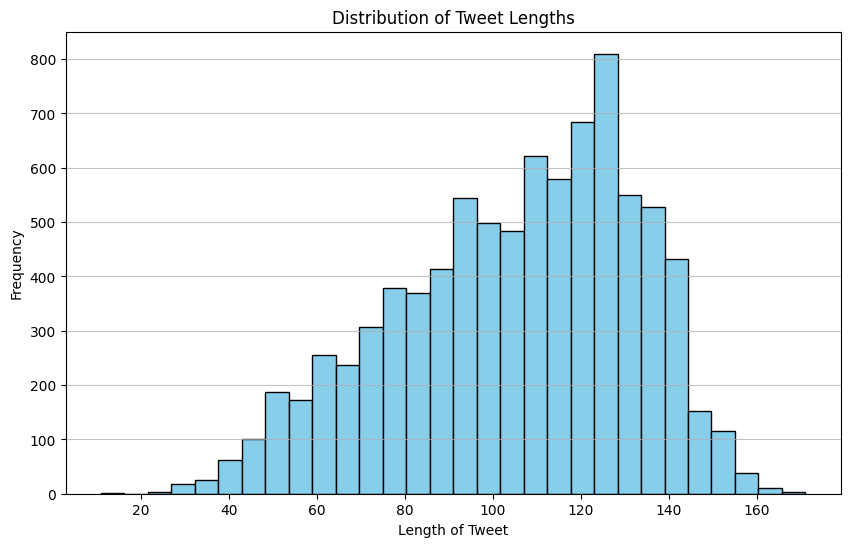

In [12]:
import matplotlib.pyplot as plt

# Plotting the distribution of tweet lengths directly
plt.figure(figsize=(10, 6))
plt.hist(training_df['tweet_text'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


**Inputation to handle null values**

In [13]:
def infer_product_from_tweet(text):
    text = text.lower()
    if 'ipad' in text:
        return 'iPad'
    elif 'iphone' in text:
        return 'iPhone'
    elif 'google' in text:
        return 'Google'
    elif 'android' in text:
        return 'Android'
    elif 'app' in text:
        return 'iPad or iPhone App'
    else:
        return 'Unknown Product'

In [14]:
# Impute missing values based on the tweet text
training_df['emotion_in_tweet_is_directed_at'] = training_df['emotion_in_tweet_is_directed_at'].fillna(
    training_df['tweet_text'].apply(infer_product_from_tweet)
)


In [15]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8588 entries, 0 to 8588
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8588 non-null   object
 1   emotion_in_tweet_is_directed_at                     8588 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8588 non-null   object
dtypes: object(3)
memory usage: 268.4+ KB


In [16]:
training_df.shape

(8588, 3)

In [17]:
training_df['emotion_in_tweet_is_directed_at'].value_counts()

,count
emotion_in_tweet_is_directed_at,
iPad,2354
Google,1998
iPad or iPhone App,1177
iPhone,1041
Unknown Product,675
Apple,661
Other Google product or service,293
Android,273
Android App,81


**Data Preprocessing**

In [20]:
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
def preprocess_data(text):
    tweet = text.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub(r'\d+', '', tweet)
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [23]:
import nltk
nltk.download('punkt')

training_df['cleaned_tweet_text'] = training_df['tweet_text'].apply(preprocess_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley, g, iphone, hrs, tweeting, riseaustin,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


In [25]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

product_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

# Encode the 'emotion_in_tweet_is_directed_at' column
training_df['emotion_in_tweet_is_directed_at'] = product_encoder.fit_transform(training_df['emotion_in_tweet_is_directed_at'])

# Encode the 'is_there_an_emotion_directed_at_a_brand_or_product' column
training_df['is_there_an_emotion_directed_at_a_brand_or_product'] = emotion_encoder.fit_transform(training_df['is_there_an_emotion_directed_at_a_brand_or_product'])


In [27]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,9,1,"[wesley, g, iphone, hrs, tweeting, riseaustin,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,8,3,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,7,3,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,8,1,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,3,3,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


# **Custom Embedding**

In [28]:
import gensim
from gensim.models import Word2Vec

processed_tweets = training_df['cleaned_tweet_text']

# Train Word2Vec model
model = Word2Vec(sentences=processed_tweets, vector_size=100, window=5, min_count=1, workers=4)

# Save model
model.save("word2vec.model")

# **Generate Embeddings**

In [29]:
import numpy as np

def get_embedding(tweet_tokens):
    # Generate embeddings for the tokens
    embeddings = [model.wv[token] for token in tweet_tokens if token in model.wv]

    # If no tokens are found, return a zero vector
    if not embeddings:
        return np.zeros(model.vector_size)

    # Average the embeddings to create a single vector for the tweet
    return np.mean(embeddings, axis=0)

# Generate embeddings for the processed tweets
tweet_embeddings = np.array([get_embedding(tokens) for tokens in processed_tweets])


In [30]:
tweet_embeddings

array([[-0.18435477,  0.26197064,  0.18261798, ..., -0.12077829,
         0.23439537,  0.30447903],
       [-0.23164527,  0.3374056 ,  0.23590882, ..., -0.15665638,
         0.28149158,  0.37964812],
       [-0.19062386,  0.46330476,  0.2652456 , ..., -0.2271337 ,
         0.35405055,  0.4090213 ],
       ...,
       [-0.09691413,  0.15618455,  0.08897571, ..., -0.04565707,
         0.14347237,  0.16749364],
       [-0.21330087,  0.34559944,  0.2104988 , ..., -0.11057584,
         0.3329282 ,  0.39887434],
       [-0.17504461,  0.57354385,  0.20185632, ..., -0.02632292,
         0.52366185,  0.49957022]], dtype=float32)

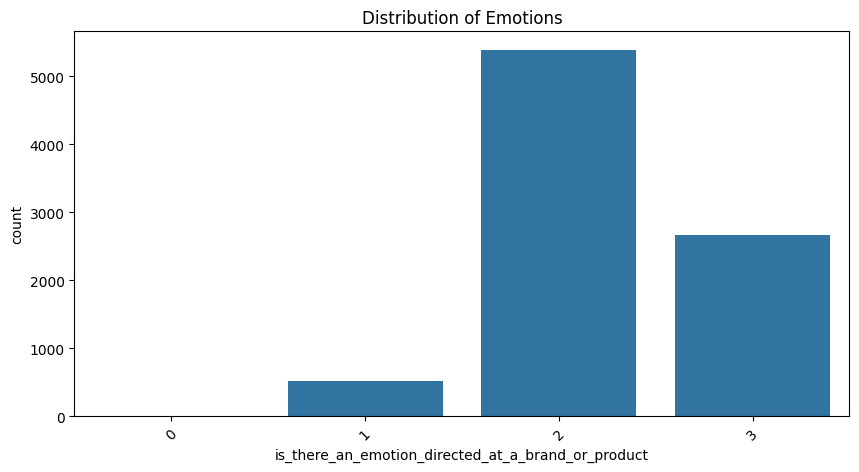

In [31]:
# Distribution of emotions
plt.figure(figsize=(10, 5))
sns.countplot(data=training_df, x='is_there_an_emotion_directed_at_a_brand_or_product')
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

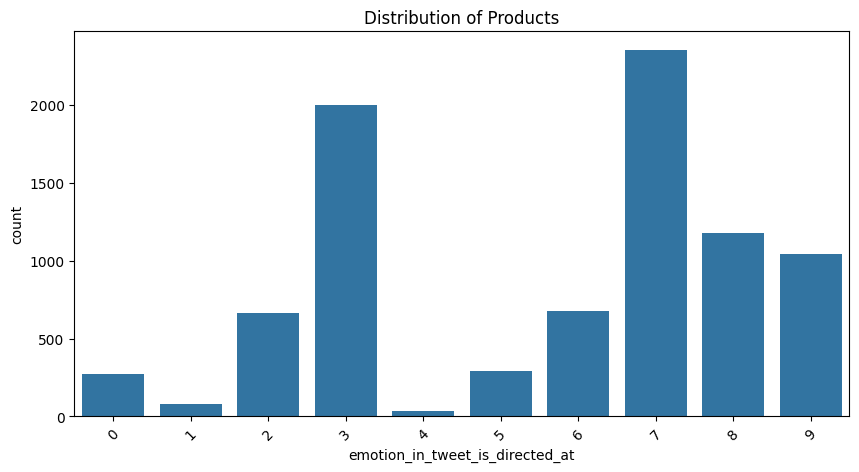

In [32]:
# Distribution of products
plt.figure(figsize=(10, 5))
sns.countplot(data=training_df, x='emotion_in_tweet_is_directed_at')
plt.title('Distribution of Products')
plt.xticks(rotation=45)
plt.show()

# **Testing Dataset**

In [33]:
testing_df = pd.read_csv('/kaggle/input/wysaai/NLP Engineer Assignment Dataset (1).xlsx - Test.csv')

In [34]:
testing_df.shape

(504, 1)

In [35]:
#check null values
testing_df.isnull().sum()

,0
Tweet,0


In [36]:
testing_df.head()

,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...
1,Again? RT @mention Line at the Apple store is ...
2,Boooo! RT @mention Flipboard is developing an ...
3,Thanks to @mention for publishing the news of ...
4,���@mention &quot;Apple has opened a pop-up st...


In [37]:

# Correct line to apply the preprocessing function
testing_df['Cleaned_Tweet'] = testing_df['Tweet'].apply(preprocess_data)


In [38]:
testing_df['Tweet']

,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...
1,Again? RT @mention Line at the Apple store is ...
2,Boooo! RT @mention Flipboard is developing an ...
3,Thanks to @mention for publishing the news of ...
4,���@mention &quot;Apple has opened a pop-up st...
...,...
499,Hey is anyone doing #sxsw signing up for the g...
500,@mention you can buy my used iPad and I'll pic...
501,@mention You could buy a new iPad 2 tmrw at th...
502,"Guys, if you ever plan on attending #SXSW, you..."


In [41]:
# Convert DataFrame to Hugging Face Dataset format
#dataset = Dataset.from_pandas(training_df[['cleaned_tweet_text','emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']])


NameError: name 'Dataset' is not defined

# **Model Initialization**

In [40]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,9,1,"[wesley, g, iphone, hrs, tweeting, riseaustin,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,8,3,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,7,3,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,8,1,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,3,3,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


In [42]:
# Check if the columns exist in training_df
required_columns = ['cleaned_tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']

for col in required_columns:
    if col not in training_df.columns:
        raise ValueError(f"Column '{col}' is missing from the DataFrame.")

In [43]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_texts, val_texts, train_product_labels, val_product_labels, train_emotion_labels, val_emotion_labels = train_test_split(
    training_df['cleaned_tweet_text'].tolist(),
    training_df['emotion_in_tweet_is_directed_at'].tolist(),
    training_df['is_there_an_emotion_directed_at_a_brand_or_product'].tolist(),
    test_size=0.2,
    random_state=42
)

In [44]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [45]:
# Ensure train_texts and val_texts are lists of strings
train_texts = [' '.join(text) for text in train_texts]
val_texts = [' '.join(text) for text in val_texts]


In [46]:
# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")


In [47]:
train_encodings = {key: val.tolist() for key, val in train_encodings.items()}
val_encodings = {key: val.tolist() for key, val in val_encodings.items()}


In [48]:
# Define a custom dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, product_labels, emotion_labels):
        self.encodings = encodings
        self.product_labels = product_labels
        self.emotion_labels = emotion_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['product_labels'] = torch.tensor(self.product_labels[idx])
        item['emotion_labels'] = torch.tensor(self.emotion_labels[idx])
        return item

    def __len__(self):
        return len(self.product_labels)

In [49]:
train_dataset = TweetDataset(train_encodings, train_product_labels, train_emotion_labels)
val_dataset = TweetDataset(val_encodings, val_product_labels, val_emotion_labels)


In [111]:
class DistilBertForMultiTaskClassification(nn.Module):
    def __init__(self, num_product_labels, num_emotion_labels):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.5)
        self.product_classifier = nn.Linear(self.distilbert.config.hidden_size, num_product_labels)
        self.emotion_classifier = nn.Linear(self.distilbert.config.hidden_size, num_emotion_labels)

    def forward(self, input_ids, attention_mask, product_labels=None, emotion_labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0]  # Take the [CLS] token representation
        pooled_output = self.dropout(pooled_output)

        product_logits = self.product_classifier(pooled_output)
        emotion_logits = self.emotion_classifier(pooled_output)

        loss = None
        if product_labels is not None and emotion_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            product_loss = loss_fct(product_logits, product_labels)
            emotion_loss = loss_fct(emotion_logits, emotion_labels)
            loss = product_loss + emotion_loss

        return {'loss': loss, 'product_logits': product_logits, 'emotion_logits': emotion_logits}


In [112]:
# Initialize the model
num_product_labels = len(set(train_product_labels))
num_emotion_labels = len(set(train_emotion_labels))
model = DistilBertForMultiTaskClassification(num_product_labels, num_emotion_labels)


In [113]:
# Freeze all DistilBERT layers except the last few
for param in model.distilbert.parameters():
    param.requires_grad = False

# Optionally unfreeze the last few layers
for param in model.distilbert.transformer.layer[-2:].parameters():
    param.requires_grad = True

In [114]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to=["none"],  # Add this line to disable wandb
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-114-0e249749cf6c>, line 5)

In [115]:

def compute_metrics(pred):
    product_labels = pred.label_ids[0]
    emotion_labels = pred.label_ids[1]
    product_preds = np.argmax(pred.predictions[0], axis=1)
    emotion_preds = np.argmax(pred.predictions[1], axis=1)

    product_accuracy = (product_preds == product_labels).mean()
    emotion_accuracy = (emotion_preds == emotion_labels).mean()

    return {
        "product_accuracy": product_accuracy,
        "emotion_accuracy": emotion_accuracy,
    }

In [116]:
#Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [117]:
# Train the model
print("Training the model...")
trainer.train()

Training the model...


Epoch,Training Loss,Validation Loss,Product Accuracy,Emotion Accuracy
1,1.378000,1.292646,0.801513,0.665891
2,1.074200,1.115548,0.833527,0.699651
3,1.136600,1.075369,0.838766,0.710128
4,0.914700,1.047951,0.849825,0.714785
5,0.804500,1.047063,0.852154,0.722934


TrainOutput(global_step=2150, training_loss=1.3105879555192104, metrics={'train_runtime': 154.6636, 'train_samples_per_second': 222.095, 'train_steps_per_second': 13.901, 'total_flos': 0.0, 'train_loss': 1.3105879555192104, 'epoch': 5.0})

In [118]:
# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 1.047062873840332, 'eval_product_accuracy': 0.8521536670547147, 'eval_emotion_accuracy': 0.7229336437718277, 'eval_runtime': 1.8126, 'eval_samples_per_second': 947.786, 'eval_steps_per_second': 14.895, 'epoch': 5.0}


In [119]:
# Make predictions on the test set
test_texts = [' '.join(tweet) for tweet in testing_df['Cleaned_Tweet']]
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)
test_dataset = TweetDataset(test_encodings, [0]*len(testing_df), [0]*len(testing_df))  # Dummy labels

In [120]:
predictions = trainer.predict(test_dataset)

product_predictions = np.argmax(predictions.predictions[0], axis=1)
emotion_predictions = np.argmax(predictions.predictions[1], axis=1)

In [121]:
# For products
predicted_products = product_encoder.inverse_transform(product_predictions)

# For emotions
predicted_emotions = emotion_encoder.inverse_transform(emotion_predictions)


In [122]:
# Add predictions to the test dataframe
testing_df['Predicted_Product'] = predicted_products
testing_df['Predicted_Emotion'] = predicted_emotions

In [123]:
# Save results
testing_df.to_csv('assignment_results.csv', index=False)

print("Predictions saved to test_results1.csv")

Predictions saved to test_results1.csv


In [128]:
torch.save(model, 'MODEL.pth')
